Copyright 2019 The TensorFlow Authors.

### Dogs vs Cats Image Classification

* Concepts we learn in this tutorial
> Building pipelines with image data being loaded from hard disk using tf.keras.preprocessing.image.ImageDataGenerator, Overfitting - How to identify and solve it

### Importing libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

### Data Loading

In [5]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

In [6]:
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

In [7]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/Users/z003z7n/.keras/datasets
/Users/z003z7n/.keras/datasets/cats_and_dogs_filtered
/Users/z003z7n/.keras/datasets/cats_and_dogs_filtered/train
/Users/z003z7n/.keras/datasets/cats_and_dogs_filtered/train/dogs
/Users/z003z7n/.keras/datasets/cats_and_dogs_filtered/train/cats
/Users/z003z7n/.keras/datasets/cats_and_dogs_filtered/validation
/Users/z003z7n/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/Users/z003z7n/.keras/datasets/cats_and_dogs_filtered/validation/cats
/Users/z003z7n/.keras/datasets/fashion-mnist


In [8]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

### Understanding the data

In [9]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))
num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

In [10]:
total_train = num_cats_tr + num_dogs_tr
total_validation = num_cats_val + num_dogs_val

In [11]:
total_train

2000

In [12]:
total_validation

1000

In [13]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_validation)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [14]:
num_cats_tr

1000

### Setting model parameters

In [18]:
BATCH_SIZE = 100 # Number of training examples to process before updating our models variables
IMG_SHAPE = 150 # Our training data consists of images with width of 150 pixels and height of 150 pixels

### Data preparation

Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network. The steps involved in preparing these images are:

Read images from the disk
Decode contents of these images and convert it into proper grid format as per their RGB content
Convert them into floating point tensors
Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.
Fortunately, all these tasks can be done using the class tf.keras.preprocessing.image.ImageDataGenerator.

We can set this up in a couple of lines of code.

In [16]:
train_image_generator = ImageDataGenerator(rescale = 1./255)
validation_image_generator = ImageDataGenerator(rescale = 1./255)

After defining our generators for training and validation images, flow_from_directory method will load images from the disk, apply rescaling, and resize them using single line of code.

In [19]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [20]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


### Visualizing Training Images

We can visualize our training images by getting a batch of images from the training generator, and then plotting a few of them using matplotlib.

In [21]:
sample_training_images, _ = next(train_data_gen)

The next function returns a batch from the dataset. One batch is a tuple of (many images, many labels). For right now, we're discarding the labels because we just want to look at the images.

In [22]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

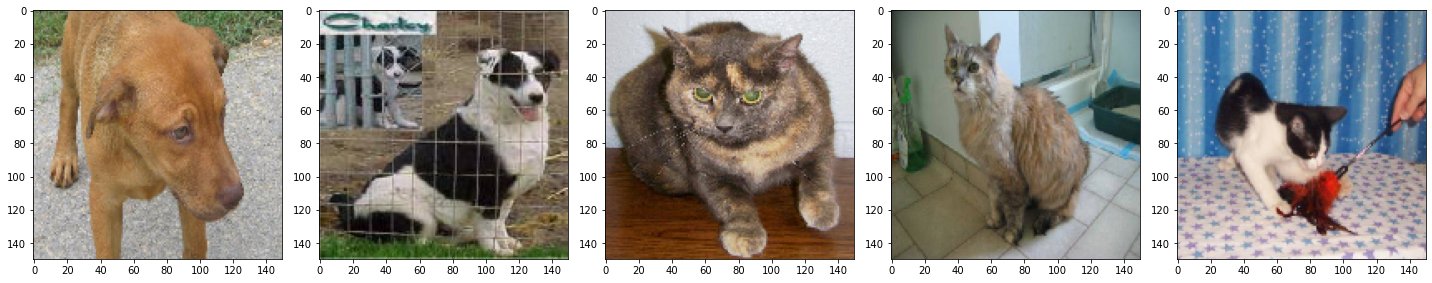

In [23]:
plotImages(sample_training_images[:5])  # Plot images 0-4

### Model Creation

Define the model
The model consists of four convolution blocks with a max pool layer in each of them. Then we have a fully connected layer with 512 units, with a relu activation function. The model will output class probabilities for two classes — dogs and cats — using softmax.

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

Compile the model
As usual, we will use the adam optimizer. Since we output a softmax categorization, we'll use sparse_categorical_crossentropy as the loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so we are passing in the metrics argument.

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model Summary

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

### Training the model

It's time we train our network.

Since our batches are coming from a generator (ImageDataGenerator), we'll use fit_generator instead of fit.

In [29]:
EPOCHS = 100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_validation / float(BATCH_SIZE)))
)

Epoch 1/100
20/20 [==============================] - 27s 1s/step - loss: 0.7232 - accuracy: 0.5165 - val_loss: 0.6880 - val_accuracy: 0.6070
Epoch 2/100
20/20 [==============================] - 28s 1s/step - loss: 0.6919 - accuracy: 0.5235 - val_loss: 0.6916 - val_accuracy: 0.5130
Epoch 3/100
20/20 [==============================] - 55s 3s/step - loss: 0.6857 - accuracy: 0.5615 - val_loss: 0.6465 - val_accuracy: 0.6400
Epoch 4/100
20/20 [==============================] - 38s 2s/step - loss: 0.6505 - accuracy: 0.6240 - val_loss: 0.6012 - val_accuracy: 0.6760
Epoch 5/100
20/20 [==============================] - 35s 2s/step - loss: 0.6056 - accuracy: 0.6790 - val_loss: 0.5636 - val_accuracy: 0.7090
Epoch 6/100
20/20 [==============================] - 39s 2s/step - loss: 0.5581 - accuracy: 0.7055 - val_loss: 0.5734 - val_accuracy: 0.7030
Epoch 7/100
20/20 [==============================] - 41s 2s/step - loss: 0.5291 - accuracy: 0.7315 - val_loss: 0.5917 - val_accuracy: 0.6880
Epoch 8/100
2

20/20 [==============================] - 36s 2s/step - loss: 6.5742e-05 - accuracy: 1.0000 - val_loss: 1.5910 - val_accuracy: 0.7840
Epoch 59/100
20/20 [==============================] - 37s 2s/step - loss: 6.2739e-05 - accuracy: 1.0000 - val_loss: 1.5972 - val_accuracy: 0.7830
Epoch 60/100
20/20 [==============================] - 38s 2s/step - loss: 6.0199e-05 - accuracy: 1.0000 - val_loss: 1.6022 - val_accuracy: 0.7840
Epoch 61/100
20/20 [==============================] - 41s 2s/step - loss: 5.7825e-05 - accuracy: 1.0000 - val_loss: 1.6080 - val_accuracy: 0.7840
Epoch 62/100
20/20 [==============================] - 38s 2s/step - loss: 5.5535e-05 - accuracy: 1.0000 - val_loss: 1.6136 - val_accuracy: 0.7830
Epoch 63/100
20/20 [==============================] - 36s 2s/step - loss: 5.3423e-05 - accuracy: 1.0000 - val_loss: 1.6199 - val_accuracy: 0.7840
Epoch 64/100
20/20 [==============================] - 36s 2s/step - loss: 5.1402e-05 - accuracy: 1.0000 - val_loss: 1.6247 - val_accuracy

In [31]:
history.history

{'loss': [0.7231569886207581,
  0.6918502449989319,
  0.685676634311676,
  0.6504862308502197,
  0.6056278347969055,
  0.5580693483352661,
  0.529147744178772,
  0.5100818276405334,
  0.48300060629844666,
  0.42681241035461426,
  0.39755353331565857,
  0.36626681685447693,
  0.31441089510917664,
  0.27394017577171326,
  0.2764919400215149,
  0.21536438167095184,
  0.14749623835086823,
  0.11816013604402542,
  0.12808257341384888,
  0.09056511521339417,
  0.06569556146860123,
  0.03705234080553055,
  0.016191160306334496,
  0.012328572571277618,
  0.014436458237469196,
  0.016083577647805214,
  0.023773977532982826,
  0.015830380842089653,
  0.03130771964788437,
  0.04882241412997246,
  0.01673882082104683,
  0.010228259488940239,
  0.0037381434813141823,
  0.001188583206385374,
  0.0005441351677291095,
  0.0004014621372334659,
  0.0003163315122947097,
  0.0002714005240704864,
  0.0002354385214857757,
  0.00021285055845510215,
  0.00019054212316405028,
  0.00017336914606858045,
  0.0001

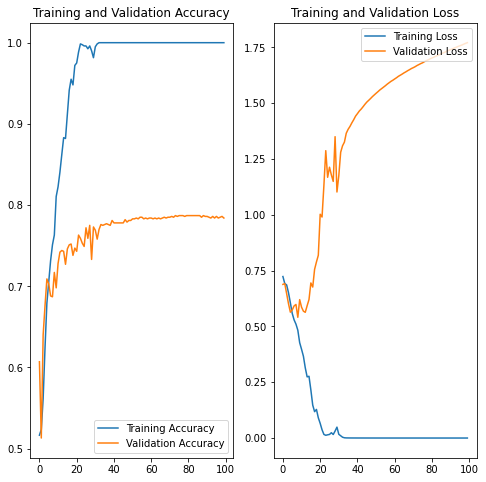

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

As we can see from the plots, training accuracy and validation accuracy are off by large margin and our model has achieved only around 70% accuracy on the validation set (depending on the number of epochs you trained for).

This is a clear indication of overfitting. Once the training and validation curves start to diverge, our model has started to memorize the training data and is unable to perform well on the validation data.

Note:

We have used 2 inputs in the last layer and used softmax to classify between dogs and cats.

tf.keras.layers.Dense(2, activation='softmax')

If we use the sigmoid based binary classification, we use the following layer

tf.keras.layers.Dense(1, activation='sigmoid')

In the above case, the loss parameter in the model.compile() should be 'binary_crossentropy' instead of 'saprse_categorical_crossentropy'